Project for machine learning - Mushroom classification

This project is about mushroom classification into two categories - edible or poisonous. Firstly, I will try to cover as much information about dataset as possible, then I will try to use some machine learning methods for creating models to predict mushrooms types and at the end I will conclude this project with some results and try to compare used methods.

As a very first thing, let me make sure no output will be scrollable (so we can see whole graphs at once):

In [65]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Let's begin with importing necessary tools:

Numpy : a must for machine learning and mathemathics with various usages, no need to go in details here.  
Pandas : a great tool for data manipulation and analysis. In this project, I will use it for easy data processing.  
Seaborn : used for easy confusion matrix as heat map plotting
Matplotlib : pyplot for plotting - also understandable without explanation.    
Sklearn, preproccesing : LabelEncoder - for converting string values to integers, StandardScaler - for feature scaling     
Sklearn, model_selection : train_test_split for easy data splitting, cross_val_predict, cross_val_score for results   
Sklearn, decomposition : PCA - for easy PCA usage   
Sklearn, svm : SVC for SVM model usage
Sklearn, metrics : confusion_matrix, classification_report, accuracy_score for results   
Sklearn, model_Selection : RandomizedSearchCV for finding parameters   
Sklearn, ensemble : RandomForestClassifier for RandomForest model usage   

In [67]:
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

Here I'm going to leave important helping functions - they will be used later:

In [68]:
def make_label(ax, chart):
    for info in chart:
        height = info.get_height()
        width = info.get_width()
        x = info.get_x()
        ax.text(x + width/2., 1*height, '%d' % int(height), ha='center', va='bottom', fontsize=10)
        
def plot_first_graph():
    odors = dataset['odor']
    distribution = odors.value_counts()
    distribution_list, letter_types_list = distribution.tolist(), distribution.axes[0].tolist()
    labels = {'a':'almond', 'l':'anise', 'c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'}
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
    types_list = [labels[char] for char in letter_types_list]
    fig = plt.figure(figsize=(13,10))
    plt.title('Graph 1: Mushrooms odor percentage pie graph')
    plt.pie(distribution_list, labels=types_list, colors=colors, autopct='%1.1f%%')

    plt.show()
    return letter_types_list
    
def plot_second_graph(letter_types_list):
    fig, ax = plt.subplots(figsize=(13,10))
    edibles, not_really_edibles = [], []
    for odor in letter_types_list:
        all_mushrooms = len(dataset[dataset['odor'] == odor].index)
        class_diff = len(dataset[(dataset['odor'] == odor) & (dataset['class'] == 'e')].index)
        edibles.append(class_diff)
        not_really_edibles.append(all_mushrooms - class_diff)  
    edible_chart = ax.bar(np.arange(9), edibles, 0.40, color='green')
    poisonous_chart = ax.bar(np.arange(9)+0.40, not_really_edibles, 0.40, color='red')
    ax.set_title('Graph 2: Mushrooms odor percentage edibility classes chart graph')
    ax.set_xlabel('Odor')
    ax.set_ylabel('Number of mushrooms')
    ax.set_xticks(np.arange(9) + 0.2)
    ax.set_xticklabels(tuple(types_list))
    ax.legend((edible_chart, poisonous_chart), ('edible', 'poisonous'))
    make_label(ax, edible_chart)
    make_label(ax, poisonous_chart)
    
    plt.show()
    
def visualize_results(name, model, x, y, process):
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(('red', 'green'))
    fig = plt.figure(figsize=(13,10))
    first_min, first_max = x[:,0].min()-1, x[:,0].max()+1
    second_min, second_max = x[:,1].min()-1, x[:,1].max()+1
    step = 0.01
    x1, x2 = np.meshgrid(np.arange(start=first_min, stop=first_max, step=step), np.arange(start=second_min, stop=second_max, step=step))
    plt.contourf(x1, x2, model.predict(np.array([x1.ravel(), x2.ravel()]).transpose()).reshape(x1.shape), alpha=0.6, cmap=cmap)
    plt.xlim(x1.min(), x1.max())
    plt.ylim(x2.min(), x2.max())
    for i, j in enumerate(np.unique(y)):
        plt.scatter(x[y == j, 0], x[y == j, 1], color=cmap(i), label=j)
    graph_number = "Graph "
    if name == "default SVM":
        if process == "Training":
            graph_number += "4:"
        else:
            graph_number += "6:"
    elif name == "SVM with best parameters":
        if process == "Training":
            graph_number += "8:"
        else:
            graph_number += "10:"
    elif name == "default RF":
        if process == "Training":
            graph_number += "12:"
        else:
            graph_number += "14:"
    elif name == "RF with best parameters":
        if process == "Training":
            graph_number += "16:"
        else:
            graph_number += "18:"   
    plt.title("{} Plot of {} with {} model".format(graph_number, process, name))
    plt.xlabel("First feature")
    plt.ylabel("Second feature")
    plt.legend()
    
    plt.show()
    
def get_score(model, x, y, process):
    print("{} results:".format(process))
    print("Accuracy: {}".format(accuracy_score(y, model.predict(x))))
    print("Classification Report:\n{}".format(classification_report(y, model.predict(x))))
    matrix = confusion_matrix(y, model.predict(x))
    print("Confusion Matrix:\n{}".format(matrix))
    if process == "Training":
        result = cross_val_score(model, x, y, cv=10, n_jobs=1, scoring='accuracy')
        print("Average Accuracy: {}".format(result.mean()))
        print("Standard Deviation: {}".format(result.std()))
    return matrix

def get_svm_parameters(state):
    svm = SVC(random_state=state)
    params = {
        'C': [0.01, 1, 10, 100, 500], 'kernel': ['linear', 'rbf'],
        'C': [0.01, 1, 10, 100, 500], 'gamma': [1, 0.1, 0.001, 0.001, 0.0001], 'kernel': ['rbf']
        }
    model = RandomizedSearchCV(estimator=svm, param_distributions=params, random_state=state, cv=5) #specifying cv explicitly to silence warning
    return model

def get_rf_parameters(state):
    rf = RandomForestClassifier(random_state=state)
    params = {
        'max_features' : ['auto', 'sqrt', 'log2'],
        'criterion' : ['gini', 'entropy'],
        'n_estimators' : [10, 30, 50, 60, 70, 80, 90, 100],
        'min_samples_leaf' : [1, 5, 10, 20, 40, 60, 90, 100]
    }
    model = RandomizedSearchCV(estimator=rf, param_distributions=params, random_state=state, cv=5) #specifying cv explicitly to silence warning
    return model

def plot_confusion_matrix(matrix, status):  #NOTE: if labels in heatmap are not centered, it is current matplotlib's fault. Downgrade to 3.1.0 for a while to fix this issue
    df_cm = pd.DataFrame(matrix, range(2),
                  range(2))
    fig = plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, fmt='g')
    
    status_array = status.split(",")
    process = status_array[1]
    name = status_array[0]
    order_number = status_array[2]
    model = ""
    graph_number = "Graph "
    if name == "SVM":
        if order_number == "1":
            model = "default SVM"
            if process == "Training":
                graph_number += "3:"
            else:
                graph_number += "5:"
        else:
            model = "SVM with best parameters"
            if process == "Training":
                graph_number += "7:"
            else:
                graph_number += "9:"
    elif name == "RF":
        if order_number == "1":
            model = "default RF"
            if process == "Training":
                graph_number += "11:"
            else:
                graph_number += "13:"
        else:
            model = "RF with best parameters"
            if process == "Training":
                graph_number += "15:"
            else:
                graph_number += "17:"
    plt.title("{} Confusion matrix of {} with {} model".format(graph_number, process, model))
    plt.show()
    

First part of this project is all about dataset - importing, analysis, editing etc. Of course, the very first thing should be importing dataset - I will save it into variable dataset.

In [21]:
dataset = pd.read_csv("data/mushrooms.csv")

How big is our dataset? There is an easy way to find out:

In [22]:
dataset.shape

(8124, 23)

Let's see how does the dataset look. Statement below will show first k (in this case, I chose 10) rows of the data with column info. 

In [23]:
dataset.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


We can see that dataset contains 23 features (we already knew this when printing shape). Every feature somehow describes some mushroom. 

First feature - named class - is the most important part which we are going to predict. Values of this feature are p (poisonous) and e (edible).

Every other feature is also somehow describing mushroom. Column names are great info about the features, in most cases they already covers what that particular features describes. For us, it's not really important to write here about every feature values details, but just for example: cap-shape can be b (bell), c (conical), x (convex), f (flat), k (knobbed) or s (sunken).

Some valuable info can be also seen thanks to function describe(). This function will take the data, and count number of values. It will also tell us how many unique variables are there, and which is the most frequent. Let's take a look:

In [24]:
dataset.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


We could already make some interesting analysis, but let's just leave it as it is. The only important thing right now is that the edible and poisonous classes seem pretty balanced (and that is good!). To check it properly, we can call this function:

In [25]:
dataset.groupby('class').size()

class
e    4208
p    3916
dtype: int64

One of the most (and first) important thing when analysing and editing dataset is to check whether it contains some null values. The presence of null values indicates us that some information about mushrooms is missing - what is never a good sign and should be somehow dealt with. We can easily check this fact: 

In [26]:
dataset.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

Luckily for us, there are no null values, which is really great and tells us that this dataset is probably good.

By the looking at the dataset, it seems like data are not that much different. In some features, it is understandable (e.g. veil-type or bruises). Some features should be (and hopefully are) more different though.

Despite the fact that we already know how many unique values are there in each feature (thanks to .describe() function), we can plot a graph for some feature just to make sure that some features have really many different values. Let's take for example feature odor and plot a pie chart to see real distribution:

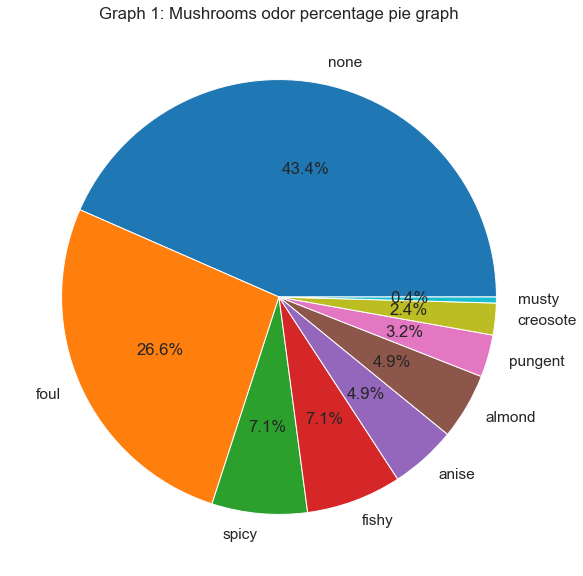

In [27]:
types_list = plot_first_graph()

We can also plot a distribution of edibility: let's join it with odor and see, what we get in a bar chart:

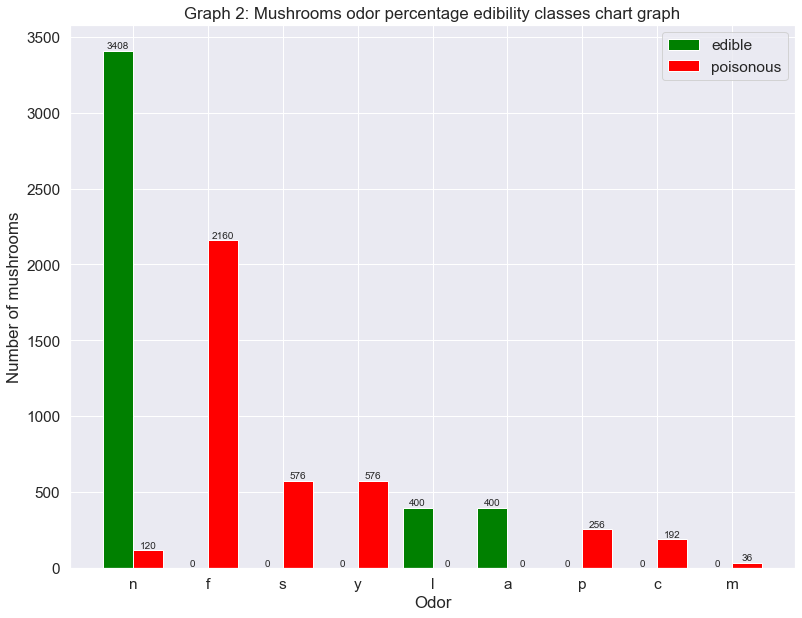

In [28]:
plot_second_graph(types_list)

We can see really interesting distribution: smelling mushrooms are always either poisonous or edible, not both (for one smell). If there is no smell, mushroom is very likely to be edible.

Of course, similar graphs could be done for more features, but I think this tells us enough now.

If we look at the dataset closely, we can see first real problem : all values from features are not integer-based, but rather strings (we could feel this when making our charts). To fix this, we perform label encoding with the help of sklearn.preprocessing.LabelEncoder function fit_transform():

In [29]:
encoder = LabelEncoder()
for column in dataset.columns:
    dataset[column] = encoder.fit_transform(dataset[column])

We visualize the head of the dataset one more time to see if values are in correct type now:

In [30]:
dataset.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
5,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
6,0,0,2,8,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,2,3
7,0,0,3,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,3,3
8,1,5,3,8,1,6,1,0,1,7,...,2,7,7,0,2,1,4,2,4,1
9,0,0,2,9,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,3,3


Out next step will be splitting dataset into X/y, train/test sets; y will be feature class, X will be rest. Size of testing values will be 25% of whole dataset and I will use some random state to get the order of values always the same.

Another thing to notice is that I will use "dummy variables". I decided for this step after reading some machine-learning helping materials. It should help as a step of preprocessing for categorical data. It is possible to just use data as it is, however.

In [31]:
state = 42 #42 - magic number and also answer to everything

X = dataset.drop('class', axis=1)
y = dataset['class']

X = pd.get_dummies(X, columns=X.columns, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)


Let's see how does part of our X-train set look like now:

In [32]:
X_train.head(10)

,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,cap-surface_1,cap-surface_2,cap-surface_3,cap-color_1,cap-color_2,...,population_2,population_3,population_4,population_5,habitat_1,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6
3887,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4119,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1600,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4988,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
6757,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3128,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5891,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
6838,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4617,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3761,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


We can notice that there are not 23 nor 22, but 95 columns now. That will be no problem however, as we use PCA dimension/reduction later.

Let's perform feature scaling now:

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

I decided to make use of Principal component analysis(PCA) with number of components 2 to scale dimensions and mainly to visualize results:

In [34]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Now the second and most important part: training and testing. Let's start with simple Support Vector Machines model (SVM):

__1. SVM simple model__

In [35]:
X_tr, X_te, y_tr, y_te = X_train, X_test, y_train, y_test

svm = SVC(gamma = 'auto', random_state=state) #gamma set to auto explicitly to avoid warning
svm.fit(X_tr, y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Below are written results and also graphs, which serve as nice visualization:

__WARNING:__ Visualisation takes a little bit of time.

In [36]:
confusion_matrix_training = get_score(svm, X_tr, y_tr, "Training")

Training results:
Accuracy: 0.9292630887904152
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.93      3168
           1       0.97      0.88      0.92      2925

    accuracy                           0.93      6093
   macro avg       0.93      0.93      0.93      6093
weighted avg       0.93      0.93      0.93      6093

Confusion Matrix:
[[3097   71]
 [ 360 2565]]
Average Accuracy: 0.9287721671334923
Standard Deviation: 0.008890483871605827


In [37]:
confusion_matrix_testing = get_score(svm, X_te, y_te, "Testing")

Testing results:
Accuracy: 0.9271294928606598
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1040
           1       0.97      0.88      0.92       991

    accuracy                           0.93      2031
   macro avg       0.93      0.93      0.93      2031
weighted avg       0.93      0.93      0.93      2031

Confusion Matrix:
[[1015   25]
 [ 123  868]]


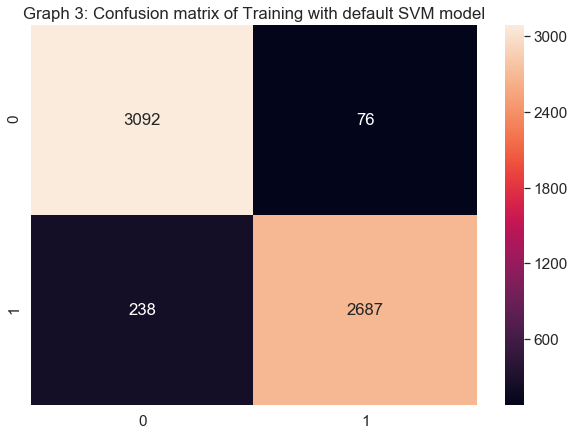

In [69]:
plot_confusion_matrix(confusion_matrix_training, "SVM,Training,1")

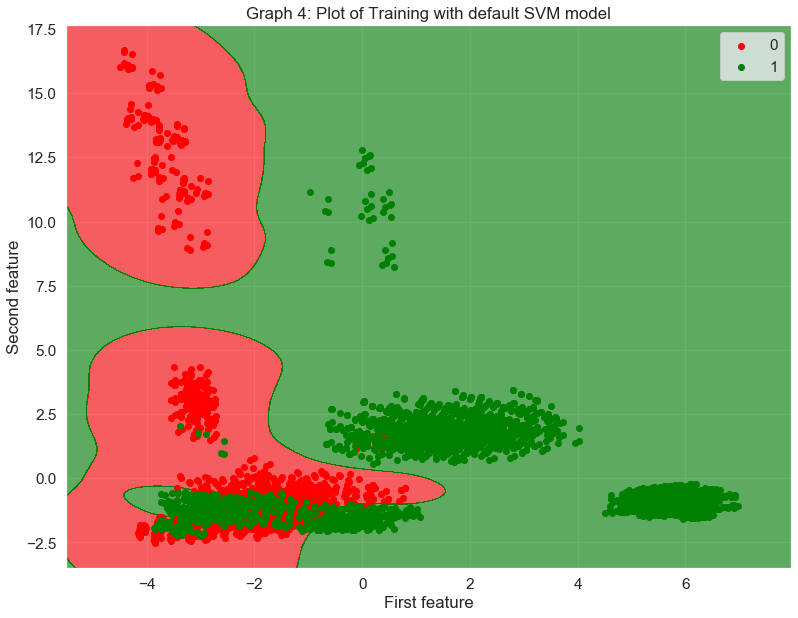

In [66]:
visualize_results('default SVM', svm, X_tr, y_tr, "Training")

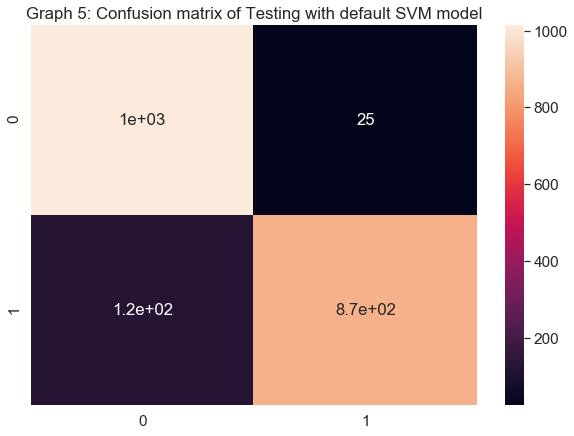

In [40]:
plot_confusion_matrix(confusion_matrix_testing, "SVM,Testing,1")

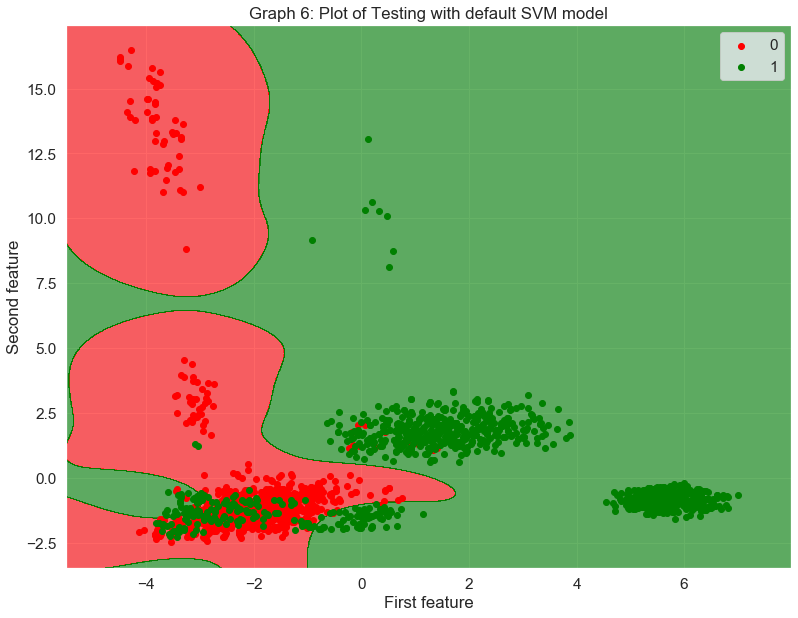

In [41]:
visualize_results('default SVM', svm, X_te, y_te, "Testing")

Results are looking really good. All resulting values of accuracy will be concluded at the end.

Now, let's try to play a little bit with parameters. We will try to find best (in the whole project, 'best' is a relative term) parameters for SVM, specifically C (regularization parameter), kernel and gamma (coefficient for some kernels) which gives the best result. For this, we can use one of another great sklearn features : GridSearchCV or RandomizedSearchCV. In this case, I will use the latter for better performance. To briefly explain this function, RandomizedSearchCV is basically random search on some hyperparameters and implements fit(), predict() and score() functions (and more). Now we will use it to find the best C and kernel (gamma possibly).

So, let's do it!

__WARNING:__ Also finding parameters can take a little bit of time.

__2. SVM model with best parameters__

In [42]:
X_tr, x_te, y_tr, y_te = X_train, X_test, y_train, y_test

mod = get_svm_parameters(state)
mod.fit(X_tr, y_tr)
svm = mod.best_estimator_
print(svm)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)


Again, computing scores and plotting graphs yields interesting results:

In [43]:
confusion_matrix_training = get_score(svm, X_tr, y_tr, "Training")

Training results:
Accuracy: 0.9327096668307895
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3168
           1       0.97      0.89      0.93      2925

    accuracy                           0.93      6093
   macro avg       0.94      0.93      0.93      6093
weighted avg       0.94      0.93      0.93      6093

Confusion Matrix:
[[3078   90]
 [ 320 2605]]
Average Accuracy: 0.9325461583580206
Standard Deviation: 0.008440418936419098


In [44]:
confusion_matrix_testing = get_score(svm, X_te, y_te, "Testing")

Testing results:
Accuracy: 0.9286065977351059
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1040
           1       0.96      0.89      0.92       991

    accuracy                           0.93      2031
   macro avg       0.93      0.93      0.93      2031
weighted avg       0.93      0.93      0.93      2031

Confusion Matrix:
[[1005   35]
 [ 110  881]]


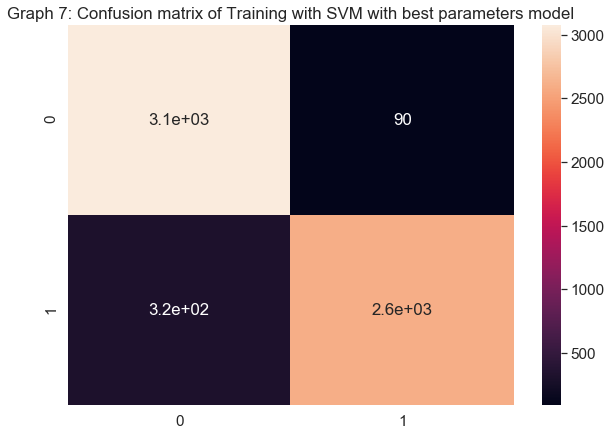

In [45]:
plot_confusion_matrix(confusion_matrix_training, "SVM,Training,2")

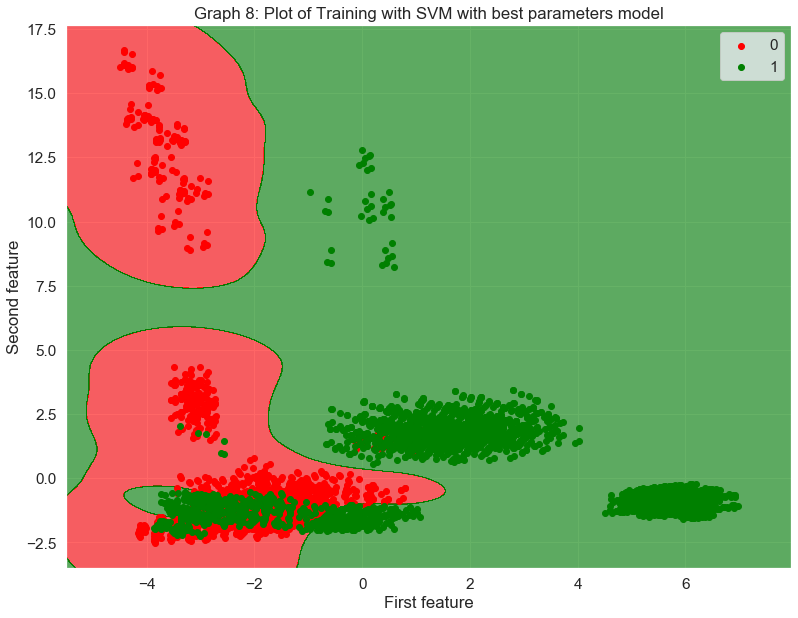

In [46]:
visualize_results('SVM with best parameters', svm, X_tr, y_tr, "Training")

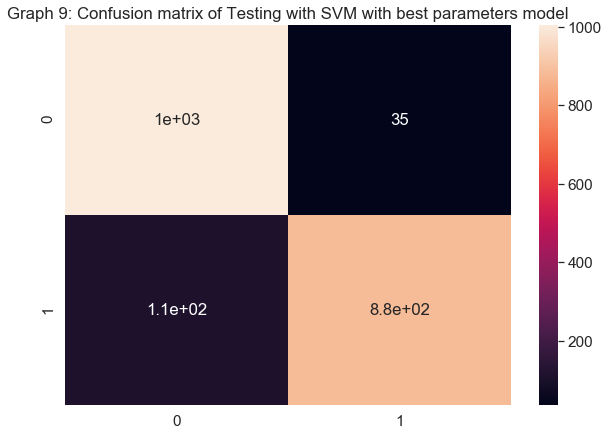

In [47]:
plot_confusion_matrix(confusion_matrix_testing, "SVM,Testing,2")

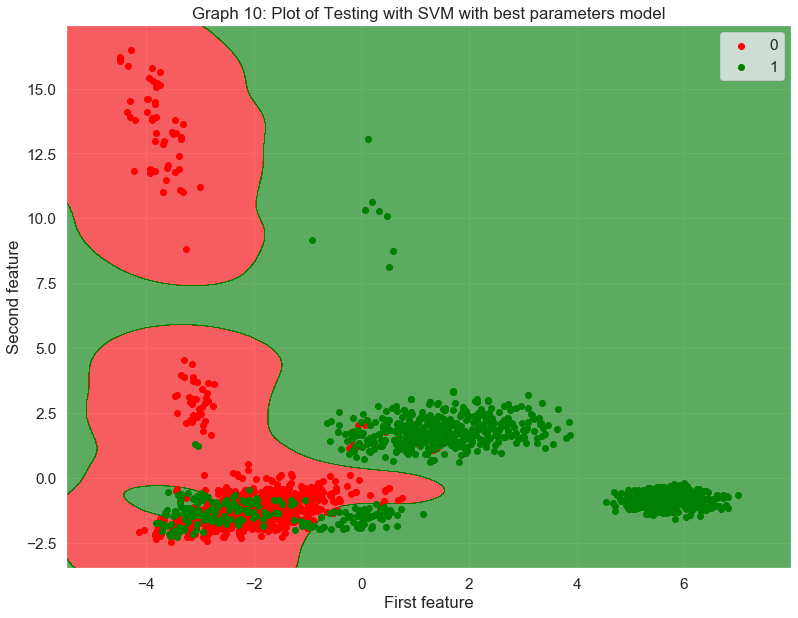

In [48]:
visualize_results('SVM with best parameters', svm, X_te, y_te, "Testing")

Let's now switch to another interesting model: Random Forrest. Again, I will divide this into 2 parts: simple model and model with best parameters.

__3. Random Forrest simple model__

In [49]:
X_tr, X_te, y_tr, y_te = X_train, X_test, y_train, y_test

rf = RandomForestClassifier(random_state=state, n_estimators=10) #setting n_estimators explicitly to silence warning
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Let's see what we can get with this model:

In [50]:
confusion_matrix_training = get_score(rf, X_tr, y_tr, "Training")

Training results:
Accuracy: 0.9896602658788775
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3168
           1       1.00      0.98      0.99      2925

    accuracy                           0.99      6093
   macro avg       0.99      0.99      0.99      6093
weighted avg       0.99      0.99      0.99      6093

Confusion Matrix:
[[3163    5]
 [  58 2867]]
Average Accuracy: 0.9235192586823191
Standard Deviation: 0.011321556116010696


In [51]:
confusion_matrix_testing = get_score(rf, X_te, y_te, "Testing")

Testing results:
Accuracy: 0.9276218611521418
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1040
           1       0.96      0.89      0.92       991

    accuracy                           0.93      2031
   macro avg       0.93      0.93      0.93      2031
weighted avg       0.93      0.93      0.93      2031

Confusion Matrix:
[[1001   39]
 [ 108  883]]


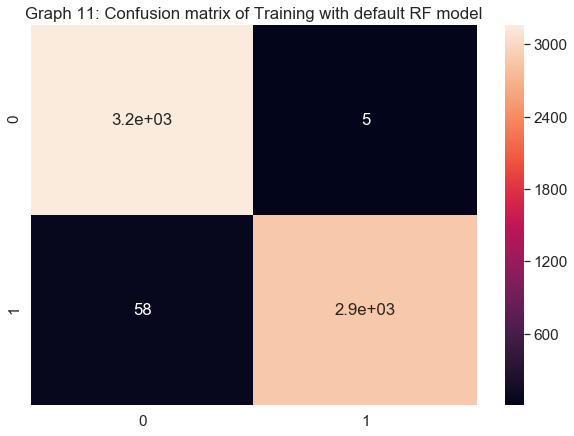

In [52]:
plot_confusion_matrix(confusion_matrix_training, "RF,Training,1")

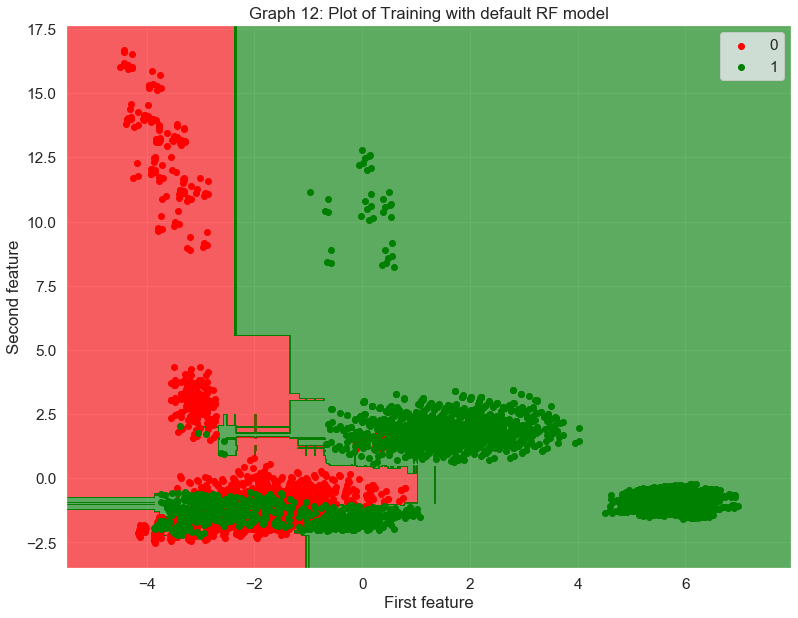

In [53]:
visualize_results('default RF', rf, X_tr, y_tr, "Training")

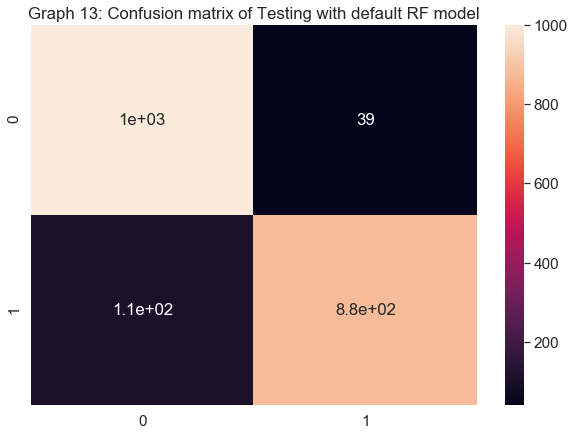

In [54]:
plot_confusion_matrix(confusion_matrix_testing, "RF,Testing,1")

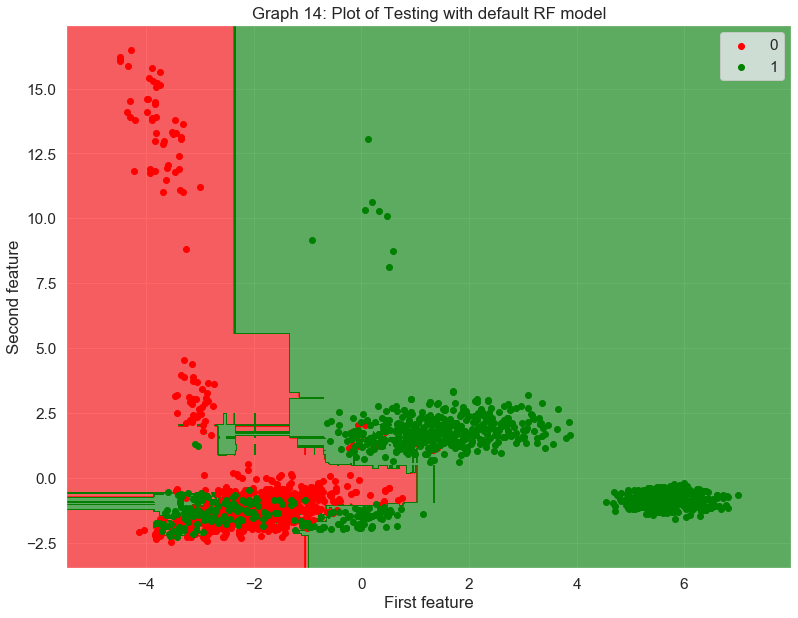

In [55]:
visualize_results('default RF', rf, X_te, y_te, "Testing")

Really impressive training accuracy! Let's try to beat testing accuracy with finding the best parameters. The parameters, which we are going to be looking for, are n_estimators (number of trees in forest), criterion (function measuring quality of split), min_samples_leaf (minimum number of sample to be leaf) and max_features (number of features when looking fo split).

__4. Random Forest model with best parameters__

In [56]:
X_tr, x_te, y_tr, y_te = X_train, X_test, y_train, y_test

mod = get_rf_parameters(state)
mod.fit(X_tr, y_tr)
rf = mod.best_estimator_
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [57]:
confusion_matrix_training = get_score(rf, X_tr, y_tr, "Training")

Training results:
Accuracy: 0.9484654521582143
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3168
           1       0.97      0.92      0.94      2925

    accuracy                           0.95      6093
   macro avg       0.95      0.95      0.95      6093
weighted avg       0.95      0.95      0.95      6093

Confusion Matrix:
[[3092   76]
 [ 238 2687]]
Average Accuracy: 0.9323846510354461
Standard Deviation: 0.009510802046674453


In [58]:
confusion_matrix_testing = get_score(rf, X_te, y_te, "Testing")

Testing results:
Accuracy: 0.931068439192516
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1040
           1       0.96      0.90      0.93       991

    accuracy                           0.93      2031
   macro avg       0.93      0.93      0.93      2031
weighted avg       0.93      0.93      0.93      2031

Confusion Matrix:
[[1002   38]
 [ 102  889]]


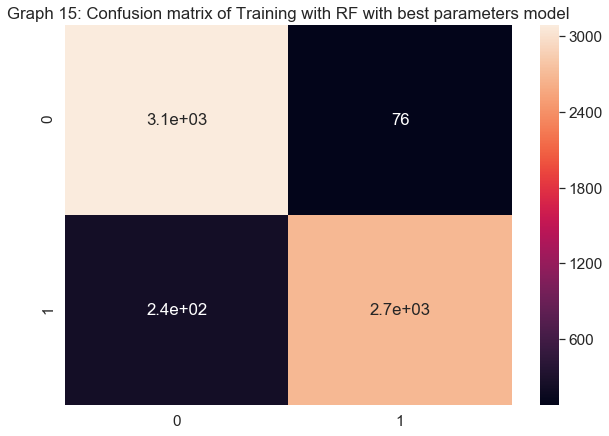

In [59]:
plot_confusion_matrix(confusion_matrix_training, "RF,Training,2")

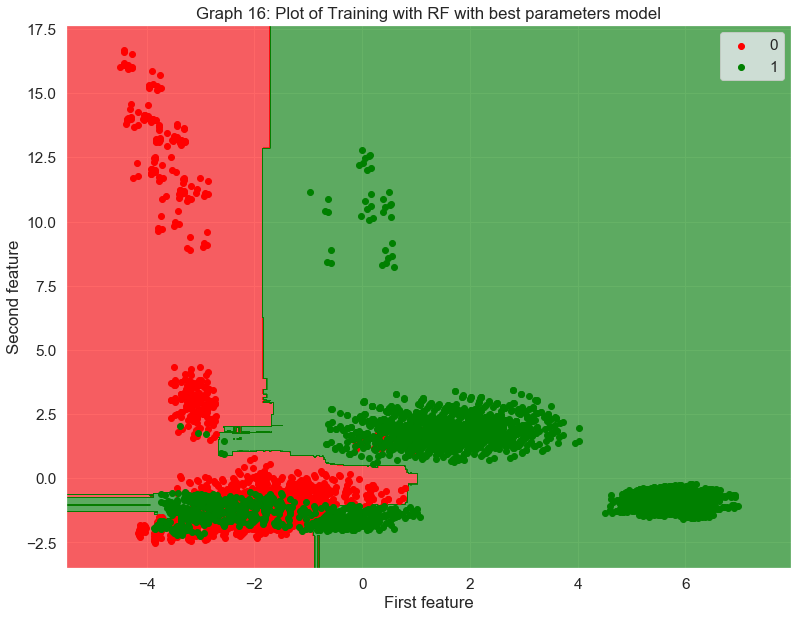

In [60]:
visualize_results('RF with best parameters', rf, X_tr, y_tr, "Training")

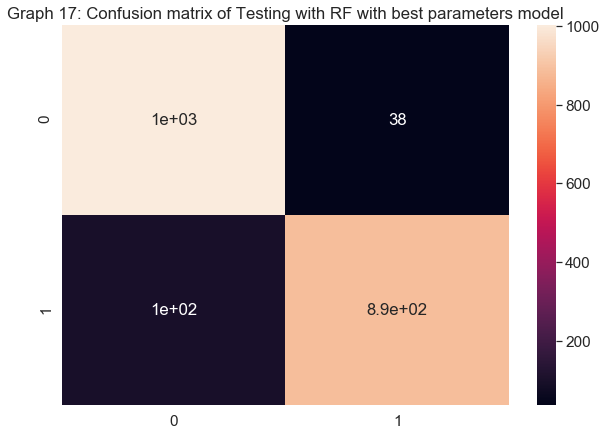

In [61]:
plot_confusion_matrix(confusion_matrix_testing, "RF,Testing,2")

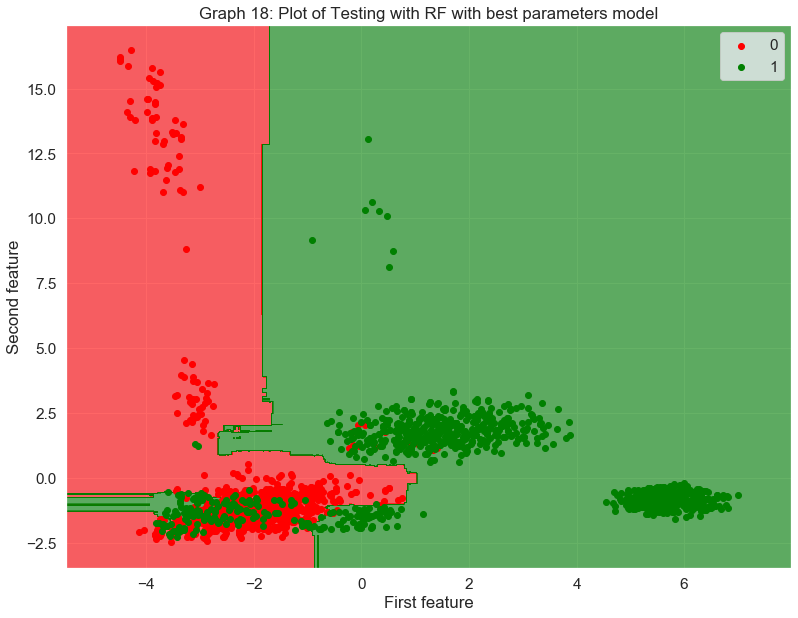

In [62]:
visualize_results('RF with best parameters', rf, X_te, y_te, "Testing")

Interesting - training accuracy has decreased, but more importantly - testing accuracy has slightly increased.